## Subset and Summarize UK Media Data

We filter the raw dataset to account for duplicated text, etc. We then normalize the outlet name, and summarize the data by media outlet.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tldextract 
import validators
import urllib


def url2domain(url, exclude_subdomains=False):
    """Extract the domain from URL.
    """
    url = urllib.parse.unquote(url)
    domain = None
    try:
        tld = tldextract.extract(url)
        a = []
        if tld.subdomain != '':
            if isinstance(exclude_subdomains, list):
                if tld.subdomain not in exclude_subdomains:
                    a.append(tld.subdomain)
            elif not exclude_subdomains :
                a.append(tld.subdomain)
        a.append(tld.domain)
        if tld.suffix != '':
            a.append(tld.suffix)
        domain = '.'.join(a)
        if not validators.domain(domain):
            domain = None
    except Exception as e:
        print(e, url)
    return domain

In [3]:
df = pd.read_csv('/opt/media_text/uk_media_clean_deduped.csv.gz', 
                 usecols = ['pubDate', 'language', 'title', 'sourceName', 'url', 'articleId', 'text'])
df.head()

,pubDate,language,title,sourceName,text,url,articleId
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001
1,13 Apr 2010 00:00:00,English,Sign up for the Celebrity SunWalk,Southern Daily Echo,fundrais prepar rise challeng power walk chall...,http://www.dailyecho.co.uk/news/charity/celebr...,en_20110203_dailyecho_483241940049
2,20 Feb 2008 12:37:00,English,"Better off in Scotland, but our readers don...",Berwick Today,better scotland reader nt want live publish da...,http://www.berwicktoday.co.uk//news/Better-off...,en_20080222_berwicktoday_079263310006
3,07 Oct 2009 04:44:00,English,Kate and Sophie shine for Britain - Sport -...,Wokingham Times,kate overman sophi lewi edgbarrow trampolin cl...,http://www.getwokingham.co.uk/sport/s/2058444_...,en_20091007_getwokingham_696604220013
4,09 Oct 2009 09:46:00,English,Birmingham Mail - Views and Blogs - Birming...,Birmingham Mail,pword aw cant grow oct maureen messent visit h...,http://www.birminghammail.net/birmingham-blogs...,en_20091009_birminghammail_699941910001


### Filter Dataset

#### 1. Subset on years where we have reasonable data

In [4]:
df['date'] = pd.to_datetime(df['pubDate'])
df['date'].dt.year.value_counts()

2009    894096
2007    892446
2008    878897
2012    736539
2013    685061
2011    508660
2010    473226
2014    368096
2006    216523
2004     16811
2003     14338
2005     14332
2015     14256
2002        59
2001        35
2000         7
1980         2
1996         1
Name: date, dtype: int64

In [5]:
df = df[(df.date>= '2003-01-01') & (df.date < '2016-01-01')]
df.shape[0]

5713281

#### 2.  Drop duplicated text

In [6]:
df = df.drop_duplicates(['text'])
df.shape[0]

5713281

#### 3. Drop Rows Where URL is Missing

In [7]:
df.dropna(subset=['url'], inplace = True)
df.shape[0]

5444828

#### Get Domains for Non-Missing URLs

In [8]:
df['domain'] = df.url.apply(lambda c: url2domain(c, exclude_subdomains = True))
df.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22 08:32:00,becclesandbungayjournal.co.uk
1,13 Apr 2010 00:00:00,English,Sign up for the Celebrity SunWalk,Southern Daily Echo,fundrais prepar rise challeng power walk chall...,http://www.dailyecho.co.uk/news/charity/celebr...,en_20110203_dailyecho_483241940049,2010-04-13 00:00:00,dailyecho.co.uk
2,20 Feb 2008 12:37:00,English,"Better off in Scotland, but our readers don...",Berwick Today,better scotland reader nt want live publish da...,http://www.berwicktoday.co.uk//news/Better-off...,en_20080222_berwicktoday_079263310006,2008-02-20 12:37:00,berwicktoday.co.uk
3,07 Oct 2009 04:44:00,English,Kate and Sophie shine for Britain - Sport -...,Wokingham Times,kate overman sophi lewi edgbarrow trampolin cl...,http://www.getwokingham.co.uk/sport/s/2058444_...,en_20091007_getwokingham_696604220013,2009-10-07 04:44:00,getwokingham.co.uk
4,09 Oct 2009 09:46:00,English,Birmingham Mail - Views and Blogs - Birming...,Birmingham Mail,pword aw cant grow oct maureen messent visit h...,http://www.birminghammail.net/birmingham-blogs...,en_20091009_birminghammail_699941910001,2009-10-09 09:46:00,birminghammail.net


#### How many rows have missing domains?

In [9]:
df[df.domain.isnull()].shape[0]

1897

There are 1,883 URLs for which we don't have domains. To understand the issue, we check the rows where the domain is missing. The small number of cases fall into one of three buckets: 1. ":" or "/" is not in the URL, 2. IP address in the URL instead of domain, and 3. There is space in the URL. Given the issue affects a tiny fraction of our data, we just drop the rows where the domain is missing.

In [10]:
df[df.domain.isnull()].head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain
219,28 Jul 2008 10:07:00,English,MixTape: It’s a life of grime for Tinchy St...,The Independent UK,tinchi stryder stage name ghanaborn grime arti...,httpblogsindependentcoukindependentmixtapeinde...,en_20080728_independent_uk_225924020031,2008-07-28 10:07:00,None
6145,16 Sep 2014 00:00:00,English,Claims of post-indy financial collapse 'exagge...,NewsNet Scotland,claim postindi financi collaps exagger say ban...,http://78.110.165.228/index.php/scottish-econo...,en_2014-09-16_b791c4a36d7f80f4da535fc31d8a3e4e...,2014-09-16 00:00:00,None
14232,07 Nov 2008 10:07:00,English,Eat: The new burger king?,The Independent UK,life beyond big mac whopper interest click exp...,httpblogsindependentcoukindependent200811eatth...,en_20081107_independent_uk_332554850000,2008-11-07 10:07:00,None
16076,26 Nov 2008 10:07:00,English,Chris Schuler: Life on Mars,The Independent UK,nida lithuania london go kaliningrad young man...,httpcschulerlivejournalcom617htmlchris-schuler...,en_20081126_independent_uk_351462880024,2008-11-26 10:07:00,None
16522,11 Dec 2008 14:07:00,English,MixTape: An open letter to Radiohead from a...,The Independent UK,much delight mani music fan south america radi...,httpcommunitylivejournalcomtimixtape2961htmlmi...,en_20081211_independent_uk_367469550018,2008-12-11 14:07:00,None


#### 5. Drop Rows Where Domain is Missing

In [11]:
cdf = df.dropna(subset = ['domain']).copy()
cdf.shape[0]

5442931

### Normalize Source Name

#### 1. Strip leading and trailing spaces in sourceName

In [12]:
cdf.sourceName = cdf.sourceName.str.strip()
cdf['sourceName'].replace('\s*\(dup\??\)', '', inplace=True, regex=True)

cdf.sourceName.head()

0    Beccles and Bungay Journal
1           Southern Daily Echo
2                 Berwick Today
3               Wokingham Times
4               Birmingham Mail
Name: sourceName, dtype: object

#### 2. Manually combine domains that track the same source

In [13]:
alias_domains = {'banburytoday.co.uk': 'banburyguardian.co.uk',
                 'berwickshire-news.co.uk': 'berwickshirenews.co.uk',
                 'berwickshiretoday.co.uk': 'berwickshirenews.co.uk',
                 'birminghammail.net': 'birminghammail.co.uk',
                 'burnleytoday.co.uk': 'burnleyexpress.net',
                 'cambs-times.co.uk': 'cambstimes.co.uk',
                 'ely-standard.co.uk': 'elystandard.co.uk',
                 'hartlepool-mail.co.uk': 'hartlepoolmail.co.uk',
                 'hemelonline.co.uk': 'hemeltoday.co.uk',
                 'hexhamcourant.co.uk': 'hexham-courant.co.uk',
                 'peterboroughet.co.uk': 'peterboroughtoday.co.uk',
                 'saffronwaldenreporter.co.uk': 'saffronwalden-reporter.co.uk',
                 'sunderland-echo.co.uk': 'sunderlandecho.com'}

In [14]:
cdf.domain = cdf.domain.replace(alias_domains)
cdf.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22 08:32:00,becclesandbungayjournal.co.uk
1,13 Apr 2010 00:00:00,English,Sign up for the Celebrity SunWalk,Southern Daily Echo,fundrais prepar rise challeng power walk chall...,http://www.dailyecho.co.uk/news/charity/celebr...,en_20110203_dailyecho_483241940049,2010-04-13 00:00:00,dailyecho.co.uk
2,20 Feb 2008 12:37:00,English,"Better off in Scotland, but our readers don...",Berwick Today,better scotland reader nt want live publish da...,http://www.berwicktoday.co.uk//news/Better-off...,en_20080222_berwicktoday_079263310006,2008-02-20 12:37:00,berwicktoday.co.uk
3,07 Oct 2009 04:44:00,English,Kate and Sophie shine for Britain - Sport -...,Wokingham Times,kate overman sophi lewi edgbarrow trampolin cl...,http://www.getwokingham.co.uk/sport/s/2058444_...,en_20091007_getwokingham_696604220013,2009-10-07 04:44:00,getwokingham.co.uk
4,09 Oct 2009 09:46:00,English,Birmingham Mail - Views and Blogs - Birming...,Birmingham Mail,pword aw cant grow oct maureen messent visit h...,http://www.birminghammail.net/birmingham-blogs...,en_20091009_birminghammail_699941910001,2009-10-09 09:46:00,birminghammail.co.uk


In [15]:
### Print Out Unique Domains
for s in sorted(cdf.domain.unique()):
    print(s)

24dash.com
BBC.co.uk
Lutontoday.co.uk
aawsat.com
aberdeen-indy.co.uk
access2insulin.org
africanecho.co.uk
agra-net.com
alertnet.org
almlook.com
alton-herald-today.co.uk
ananova.com
andoveradvertiser.co.uk
andymurray.com
apple.com
arabnewsweek.net
aria.co.uk
arm.ac.uk
artscouncil.org.uk
asharq-e.com
asharqalawsat.com
askamlocal.co.uk
aspire.org.uk
att.net
aworldtowin.net
ayrshirepost-online.co.uk
ayrshirepost.net
bailii.org
bakeryandsnacks.com
ballyclaregazette.co.uk
ballymenatimes.com
ballymenatoday.co.uk
ballymoneytimes.co.uk
ballymoneytoday.co.uk
banbridgeleader.co.uk
banbridgetoday.co.uk
banburyguardian.co.uk
banffshire-journal.co.uk
barcamp.org
barnettimes.co.uk
barnsley-chronicle.co.uk
basingstokegazette.co.uk
bbc.co.uk
bbsrc.ac.uk
bdaweightwise.com
bdpost.co.uk
becclesandbungayjournal.co.uk
becta.org.uk
bedfordtoday.co.uk
beijing2008.co
belfastmedia.com
belfasttelegraph.co.uk
belfasttoday.net
berwick-advertiser.co.uk
berwickshirenews.co.uk
berwicktoday.co.uk
bexhillobserver.net
b

#### 3. Manually Create Source Names Using Domain and SourceName

Load [manually created outlet labels](../data/uk_domain+source_label.csv) and use the label column.

In [16]:
ldf = pd.read_csv('/opt/notebooks/not_news/tabs/uk_domain+source_label.csv', usecols=['domain', 'sourceName',  'string_label'])
ldf.columns = ['label', 'domain', 'sourceName']
ldf.head()

,label,domain,sourceName
0,24dash,24dash.com,24dash
1,@W_Nuclear_News,twitter.com,@W_Nuclear_News
2,A World to Win blogs,aworldtowin.net,A World to Win blogs
3,Agra-net.com,agra-net.com,Agra-net.com
4,Al-Sharq al-Awsat,aawsat.com,Al-Sharq al-Awsat


In [17]:
ldf.shape[0]

483

In [18]:
### Merge
cdf = cdf.merge(ldf, on = ['domain', 'sourceName'], how='inner')
cdf.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain,label
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22 08:32:00,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
1,08 Jan 2010 08:23:00,English,Snow Hotline,Beccles and Bungay Journal,weather forecast remain extrem cold come day s...,http://www.becclesandbungayjournal.co.uk/conte...,en_20100108_becclesan6437_844822170000,2010-01-08 08:23:00,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
2,09 Jun 2008 08:32:00,English,Crackdown on anti-social behaviour,Beccles and Bungay Journal,elderli vulner peopl live council hous waveney...,http://www.becclesandbungayjournal.co.uk/conte...,en_20080609_becclesan6437_177751570001,2008-06-09 08:32:00,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
3,03 Nov 2008 08:32:00,English,Village cracking down on fuel bills,Beccles and Bungay Journal,villag award energysav project set spend reduc...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081103_becclesan6437_328210310001,2008-11-03 08:32:00,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
4,15 May 2009 16:32:00,English,Ace Beccles v Bungay match,Beccles and Bungay Journal,tuesday saw first beccl v bungay golf match ye...,http://www.becclesandbungayjournal.co.uk/conte...,en_20090515_becclesan6437_534951120000,2009-05-15 16:32:00,becclesandbungayjournal.co.uk,Beccles and Bungay Journal


In [19]:
cdf.shape[0]

5401695

### Subset on Outlets for Which We Have 1000 or More Transcripts

In [20]:
gdf = cdf.groupby('label').agg({'articleId': 'count'}).rename(columns={'articleId': 'article_count'})
gdf[gdf.article_count >= 1000].shape[0]

276

In [21]:
gdf[gdf.article_count >= 1000].index

Index(['24dash', 'A World to Win blogs', 'Agra-net.com', 'Al-Sharq al-Awsat',
       'Alliance for Workers' Liberty', 'Ananova', 'Andover Advertiser',
       'Ayrshire Post', 'BBC News', 'Bakery and Snacks',
       ...
       'Wisbech Standard', 'Wokingham Times', 'Worcester News',
       'Worksop Guardian', 'World Nuclear News', 'Worthing Herald',
       'Yorkshire Evening Post', 'Yorkshire Post', 'Your Local Guardian',
       'enfieldindependent.co.uk'],
      dtype='object', name='label', length=276)

In [22]:
cdf = cdf[cdf.label.isin(gdf[gdf.article_count >= 1000].index)]
cdf.shape[0]

5392953

In [23]:
cdf.loc[:, 'date'] = cdf.pubDate.astype('M8[D]')
cdf.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain,label
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
1,08 Jan 2010 08:23:00,English,Snow Hotline,Beccles and Bungay Journal,weather forecast remain extrem cold come day s...,http://www.becclesandbungayjournal.co.uk/conte...,en_20100108_becclesan6437_844822170000,2010-01-08,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
2,09 Jun 2008 08:32:00,English,Crackdown on anti-social behaviour,Beccles and Bungay Journal,elderli vulner peopl live council hous waveney...,http://www.becclesandbungayjournal.co.uk/conte...,en_20080609_becclesan6437_177751570001,2008-06-09,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
3,03 Nov 2008 08:32:00,English,Village cracking down on fuel bills,Beccles and Bungay Journal,villag award energysav project set spend reduc...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081103_becclesan6437_328210310001,2008-11-03,becclesandbungayjournal.co.uk,Beccles and Bungay Journal
4,15 May 2009 16:32:00,English,Ace Beccles v Bungay match,Beccles and Bungay Journal,tuesday saw first beccl v bungay golf match ye...,http://www.becclesandbungayjournal.co.uk/conte...,en_20090515_becclesan6437_534951120000,2009-05-15,becclesandbungayjournal.co.uk,Beccles and Bungay Journal


In [24]:
cdf.to_csv('/opt/notebooks/not_news/tabs/uk_news_media_data_subset_by_label.csv.gz', index=False, compression='gzip')

### Output Summary Table

In [25]:
sdf = cdf.groupby('label').agg({'date': [np.min, np.max], 'domain': 'count'})
sdf.columns = sdf.columns.map('_'.join)
sdf.reset_index(inplace = True)
sdf.rename(columns = {'domain_count': 'n_transcripts', 'date_amin': 'from_date', 'date_amax': 'to_date'}, inplace = True)
sdf.head()

,label,from_date,to_date,n_transcripts
0,24dash,2006-12-22,2012-04-16,43652
1,A World to Win blogs,2012-01-06,2014-09-29,1549
2,Agra-net.com,2007-03-28,2014-03-21,14391
3,Al-Sharq al-Awsat,2006-04-22,2013-02-26,35672
4,Alliance for Workers' Liberty,2003-01-27,2014-07-08,1781


In [26]:
sdf[sdf.n_transcripts > 1000].to_csv('/opt/notebooks/not_news/tabs/uk_media_clean_summarized_by_label_gt1k.csv', index = False)

### Number of Transcripts per Source per Week

In [27]:
df = cdf
df.loc[:,'week'] = df.date.dt.to_period('W')
df.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain,label,week
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-12-22/2008-12-28
1,08 Jan 2010 08:23:00,English,Snow Hotline,Beccles and Bungay Journal,weather forecast remain extrem cold come day s...,http://www.becclesandbungayjournal.co.uk/conte...,en_20100108_becclesan6437_844822170000,2010-01-08,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2010-01-04/2010-01-10
2,09 Jun 2008 08:32:00,English,Crackdown on anti-social behaviour,Beccles and Bungay Journal,elderli vulner peopl live council hous waveney...,http://www.becclesandbungayjournal.co.uk/conte...,en_20080609_becclesan6437_177751570001,2008-06-09,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-06-09/2008-06-15
3,03 Nov 2008 08:32:00,English,Village cracking down on fuel bills,Beccles and Bungay Journal,villag award energysav project set spend reduc...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081103_becclesan6437_328210310001,2008-11-03,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-11-03/2008-11-09
4,15 May 2009 16:32:00,English,Ace Beccles v Bungay match,Beccles and Bungay Journal,tuesday saw first beccl v bungay golf match ye...,http://www.becclesandbungayjournal.co.uk/conte...,en_20090515_becclesan6437_534951120000,2009-05-15,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2009-05-11/2009-05-17


In [28]:
wdf = df.groupby(['label', 'week']).agg({'label': 'count'}).rename(columns={'label': 'n_transcripts'})
wdf.head()

n_transcripts
label  week                                
24dash 2006-12-18/2006-12-24              1
       2007-01-22/2007-01-28              1
       2007-01-29/2007-02-04              1
       2007-02-26/2007-03-04              3
       2007-03-05/2007-03-11              1

In [29]:
wdf = wdf.unstack().fillna(0).stack()
wdf.head()

n_transcripts
label  week                                
24dash 2002-12-30/2003-01-05            0.0
       2003-01-06/2003-01-12            0.0
       2003-01-13/2003-01-19            0.0
       2003-01-20/2003-01-26            0.0
       2003-01-27/2003-02-02            0.0

In [30]:
xdf = wdf.groupby('label').describe()
xdf.head()

n_transcripts                                  \
                                      count       mean        std  min  25%   
label                                                                         
24dash                                626.0  69.731629  93.587135  0.0  0.0   
A World to Win blogs                  626.0   2.474441  26.042368  0.0  0.0   
Agra-net.com                          626.0  22.988818  52.560836  0.0  0.0   
Al-Sharq al-Awsat                     626.0  56.984026  61.736859  0.0  0.0   
Alliance for Workers' Liberty         626.0   2.845048   9.528229  0.0  0.0   

                                                   
                               50%     75%    max  
label                                              
24dash                         0.0  162.00  299.0  
A World to Win blogs           0.0    0.00  528.0  
Agra-net.com                   0.0    4.75  213.0  
Al-Sharq al-Awsat              7.5  127.00  166.0  
Alliance for Workers' Liberty  0.0    1.00   67.0

#### What proportion of weeks have no transcripts per outlet?

In [31]:
zdf = (wdf[wdf.n_transcripts == 0].groupby('label').count()/wdf.groupby('label').count()).rename(columns = {'n_transcripts': 'zero_transcripts'})
zdf.head()

,zero_transcripts
label,
24dash,0.568690
A World to Win blogs,0.870607
Agra-net.com,0.714058
Al-Sharq al-Awsat,0.479233
Alliance for Workers' Liberty,0.667732


In [32]:
xdf.columns = xdf.columns.levels[1]

In [33]:
odf = xdf.join(zdf)
odf.head()

,count,mean,std,min,25%,50%,75%,max,zero_transcripts
label,,,,,,,,,
24dash,626.0,69.731629,93.587135,0.0,0.0,0.0,162.00,299.0,0.568690
A World to Win blogs,626.0,2.474441,26.042368,0.0,0.0,0.0,0.00,528.0,0.870607
Agra-net.com,626.0,22.988818,52.560836,0.0,0.0,0.0,4.75,213.0,0.714058
Al-Sharq al-Awsat,626.0,56.984026,61.736859,0.0,0.0,7.5,127.00,166.0,0.479233
Alliance for Workers' Liberty,626.0,2.845048,9.528229,0.0,0.0,0.0,1.00,67.0,0.667732


In [34]:
odf.to_csv('/opt/notebooks/not_news/tabs/uk_media_clean_weekly_summarized_by_label_gt1k.csv')

### Number of Transcripts per Source by Year

In [35]:
df.loc[:,'year'] = df.date.dt.to_period('Y')
df.head()

,pubDate,language,title,sourceName,text,url,articleId,date,domain,label,week,year
0,22 Dec 2008 08:32:00,English,Anaesthetist sets up own brewery,Beccles and Bungay Journal,highpressur day work drink pint locallybrew re...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081223_becclesan6437_379770410001,2008-12-22,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-12-22/2008-12-28,2008
1,08 Jan 2010 08:23:00,English,Snow Hotline,Beccles and Bungay Journal,weather forecast remain extrem cold come day s...,http://www.becclesandbungayjournal.co.uk/conte...,en_20100108_becclesan6437_844822170000,2010-01-08,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2010-01-04/2010-01-10,2010
2,09 Jun 2008 08:32:00,English,Crackdown on anti-social behaviour,Beccles and Bungay Journal,elderli vulner peopl live council hous waveney...,http://www.becclesandbungayjournal.co.uk/conte...,en_20080609_becclesan6437_177751570001,2008-06-09,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-06-09/2008-06-15,2008
3,03 Nov 2008 08:32:00,English,Village cracking down on fuel bills,Beccles and Bungay Journal,villag award energysav project set spend reduc...,http://www.becclesandbungayjournal.co.uk/conte...,en_20081103_becclesan6437_328210310001,2008-11-03,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2008-11-03/2008-11-09,2008
4,15 May 2009 16:32:00,English,Ace Beccles v Bungay match,Beccles and Bungay Journal,tuesday saw first beccl v bungay golf match ye...,http://www.becclesandbungayjournal.co.uk/conte...,en_20090515_becclesan6437_534951120000,2009-05-15,becclesandbungayjournal.co.uk,Beccles and Bungay Journal,2009-05-11/2009-05-17,2009


In [36]:
ydf = df.groupby(['label', 'year']).agg({'label': 'count'}).rename(columns = {'label': 'n_transcripts'})
ydf.head()

n_transcripts
label  year               
24dash 2006              1
       2007           6203
       2008          10229
       2009          10013
       2010           8951

In [37]:
ydf = ydf.unstack().fillna(0).stack()
ydf.head()

n_transcripts
label  year               
24dash 2003            0.0
       2004            0.0
       2005            0.0
       2006            1.0
       2007         6203.0

In [38]:
ydf.unstack().head()

n_transcripts                            \
year                                   2003  2004  2005  2006    2007   
label                                                                   
24dash                                  0.0   0.0   0.0   1.0  6203.0   
A World to Win blogs                    0.0   0.0   0.0   0.0     0.0   
Agra-net.com                            0.0   0.0   0.0   0.0    32.0   
Al-Sharq al-Awsat                       0.0   0.0   0.0  20.0  5050.0   
Alliance for Workers' Liberty          19.0  20.0  21.0  28.0    14.0   

                                                                         \
year                              2008     2009    2010    2011    2012   
label                                                                     
24dash                         10229.0  10013.0  8951.0  7683.0   572.0   
A World to Win blogs               0.0      0.0     0.0     0.0  1098.0   
Agra-net.com                       0.0     42.0  3258.0  8246.0  1654.0   
Al-Sharq al-Awsat               4512.0   6985.0  7096.0  6784.0  4303.0   
Alliance for Workers' Liberty     18.0     15.0    10.0    22.0    25.0   

                                                    
year                             2013    2014 2015  
label                                               
24dash                            0.0     0.0  0.0  
A World to Win blogs            404.0    47.0  0.0  
Agra-net.com                   1089.0    70.0  0.0  
Al-Sharq al-Awsat               922.0     0.0  0.0  
Alliance for Workers' Liberty   587.0  1002.0  0.0

In [39]:
ydf.unstack().to_csv('/opt/notebooks/not_news/tabs/uk_media_clean_yearly_count_by_label.csv')

### Plot Number of Transcripts per Source per Year

In [40]:
%matplotlib inline

import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-white')

In [41]:
import matplotlib.colors as colors
import matplotlib.cm as cm

B = 0
E = 13*400
L = []
for i, group in ydf[B:E].groupby(level=1)['n_transcripts']:
    a = group.values
    a = np.clip(a, 0, 100000)
    L.append(a)
z = np.hstack(np.array(L).T).ravel()

Text(0.5,0.92,'Yearly number of transcripts by label (UK media)')

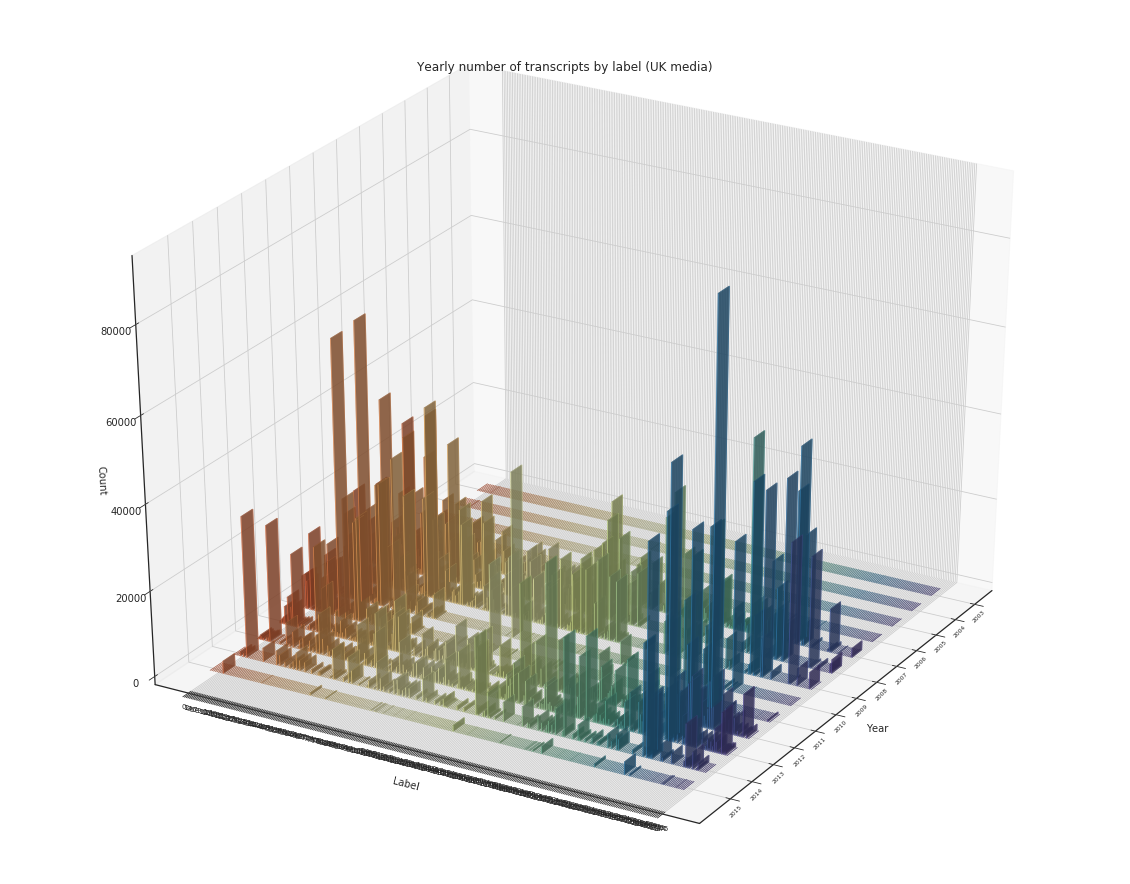

In [42]:
xlabels = ydf[B:E].index.get_level_values('year').unique()
ylabels = ydf[B:E].index.get_level_values('label').unique()
x = np.arange(xlabels.shape[0])
y = np.arange(ylabels.shape[0])

x_M, y_M = np.meshgrid(x, y, copy=False)

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(azim=30)

# Making the intervals in the axes match with their respective entries
ax.w_xaxis.set_ticks(x)
ax.w_yaxis.set_ticks(y)

# Renaming the ticks as they were before
ax.w_xaxis.set_ticklabels(xlabels)
plt.xticks(rotation = 45, fontsize = 6, va = 'center', ha = 'right')
plt.yticks(fontsize = 7, va = 'center', ha = 'left')

# Labeling the 3 dimensions
ax.set_xlabel('Year')
ax.set_ylabel('Label')
ax.set_zlabel('Count')

# Choosing the range of values to be extended in the set colormap
values = np.linspace(0.2, 1., x_M.ravel().shape[0])

# Selecting an appropriate colormap
colors = plt.cm.Spectral(values)

ax.bar3d(x_M.ravel(), y_M.ravel(), z*0, dx=0.5, dy=0.5, dz=z, color=colors, alpha=0.6)
ax.set_title('Yearly number of transcripts by label (UK media)')